# Speech Emotion Recognition
# LSTM Model

## 01) Importing Libraries

In [ ]:
import sys
import os
import random
import math
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns

SRC_PATH = "../"
if SRC_PATH not in sys.path:
    sys.path.append(os.path.abspath(SRC_PATH))

from data_utils import load_data_pt, stratified_split, loss_accuracy_graphs, train_epoch, evaluate

## 02) Setting Default Values

In [3]:
DATA_PATH = '../../data/extracted/ravdess_features_balanced_rebalanced.pt'
OUT_DIR = '../../models/LSTM'

SEED = 42
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
PATIENCE = 6

print(f"DATA_PATH : '{DATA_PATH}'")
print(f"OUT_DIR : '{OUT_DIR}'")
print(f"Device : {DEVICE}")

DATA_PATH : '../../data/extracted/ravdess_features_balanced_rebalanced.pt'
OUT_DIR : '../../models/LSTM'
Device : cuda


## 03) Creating the LSTM Model

In [4]:
class LSTMClassifier(nn.Module):
    def __init__(self, feat_dim, hidden=128, n_layers=2, n_classes=8, bidirectional=True):
        super().__init__()
        self.lstm = nn.LSTM(input_size=feat_dim, hidden_size=hidden,
                            num_layers=n_layers, batch_first=True,
                            bidirectional=bidirectional, dropout=0.2)
        self.fc = nn.Sequential(
            nn.Linear(hidden * (2 if bidirectional else 1), 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, n_classes)
        )

    def forward(self, x):
        out, _ = self.lstm(x)
        last = out.mean(dim=1)
        return self.fc(last)

## 04) Creating the Training Method for LSTM Model

In [5]:
def train(X, y, meta, epochs, batch_size, lr):
    random.seed(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    N, T, D = X.shape

    X_train, y_train, X_validation, y_validation, X_test, y_test = stratified_split(X, y)
    print("Splits: Train -", X_train.shape[0], ", Validation -", X_validation.shape[0], ", Test -", X_test.shape[0])

    train_dataset = TensorDataset(X_train, y_train)
    validation_dataset = TensorDataset(X_validation, y_validation)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)

    model = LSTMClassifier(feat_dim=D, n_classes=8).to(DEVICE)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    best_validation = 0.0
    
    os.makedirs(OUT_DIR, exist_ok=True)
    patience = 0

    loss_accuracy_data =  {"epochs": [], "train_loss" : [], "train_accuracy" : [], "validation_loss" : [], "validation_accuracy" : []}

    for epoch in range(1, epochs+1):
        train_loss, train_accuracy = train_epoch(model, train_loader, optimizer, criterion, DEVICE)
        validation_loss, validation_accuracy = evaluate(model, validation_loader, criterion, DEVICE)

        loss_accuracy_data["epochs"].append(epoch)
        loss_accuracy_data["train_loss"].append(train_loss)
        loss_accuracy_data["train_accuracy"].append(train_accuracy)
        loss_accuracy_data["validation_loss"].append(validation_loss)
        loss_accuracy_data["validation_accuracy"].append(validation_accuracy)
        
        print(f"[LSTM] Epoch {epoch} TrainLoss {train_loss:.4f} TrainAccuracy {train_accuracy:.4f} ValidationLoss {validation_loss:.4f} ValidationAccuracy {validation_accuracy:.4f}")
        if validation_accuracy > best_validation:
            best_validation = validation_accuracy
            best_model = model.state_dict()
            best_meta = meta
            patience = 0
        else:
            patience += 1
        if patience >= PATIENCE:
            print("Early stopping.")
            break

    loss_accuracy_graphs(loss_accuracy_data)
    
    return model.state_dict(), meta, best_model, best_meta, X_test, y_test

## 05) Load the Dataset

In [6]:
X, y, meta = load_data_pt(DATA_PATH)
print("Size of Loaded Data:", X.shape, "\nSize of Labels:", y.shape, "\nDevice:", DEVICE)

Size of Loaded Data: torch.Size([3072, 228, 180]) 
Size of Labels: torch.Size([3072]) 
Device: cuda


## 06) Training the Model with Different Hyperparameter Values

### (i) Training the Model with these Hyperparameter Values
- Epochs = 30
- Batch Size = 32
- Learning Rate = 1e-3 = 0.001

Splits: Train - 2457 , Validation - 307 , Test - 308
[LSTM] Epoch 1 TrainLoss 1.8634 TrainAccuracy 0.2336 ValidationLoss 1.6994 ValidationAccuracy 0.3648
[LSTM] Epoch 2 TrainLoss 1.6309 TrainAccuracy 0.3525 ValidationLoss 1.5360 ValidationAccuracy 0.4691
[LSTM] Epoch 3 TrainLoss 1.3911 TrainAccuracy 0.4681 ValidationLoss 1.2334 ValidationAccuracy 0.5472
[LSTM] Epoch 4 TrainLoss 1.1519 TrainAccuracy 0.5726 ValidationLoss 1.0816 ValidationAccuracy 0.6091
[LSTM] Epoch 5 TrainLoss 0.9108 TrainAccuracy 0.6606 ValidationLoss 0.9118 ValidationAccuracy 0.6808
[LSTM] Epoch 6 TrainLoss 0.8027 TrainAccuracy 0.7110 ValidationLoss 0.7717 ValidationAccuracy 0.7394
[LSTM] Epoch 7 TrainLoss 0.6420 TrainAccuracy 0.7648 ValidationLoss 0.7653 ValidationAccuracy 0.7524
[LSTM] Epoch 8 TrainLoss 0.4942 TrainAccuracy 0.8225 ValidationLoss 0.5109 ValidationAccuracy 0.7883
[LSTM] Epoch 9 TrainLoss 0.3679 TrainAccuracy 0.8718 ValidationLoss 0.4418 ValidationAccuracy 0.8567
[LSTM] Epoch 10 TrainLoss 0.3199 Train

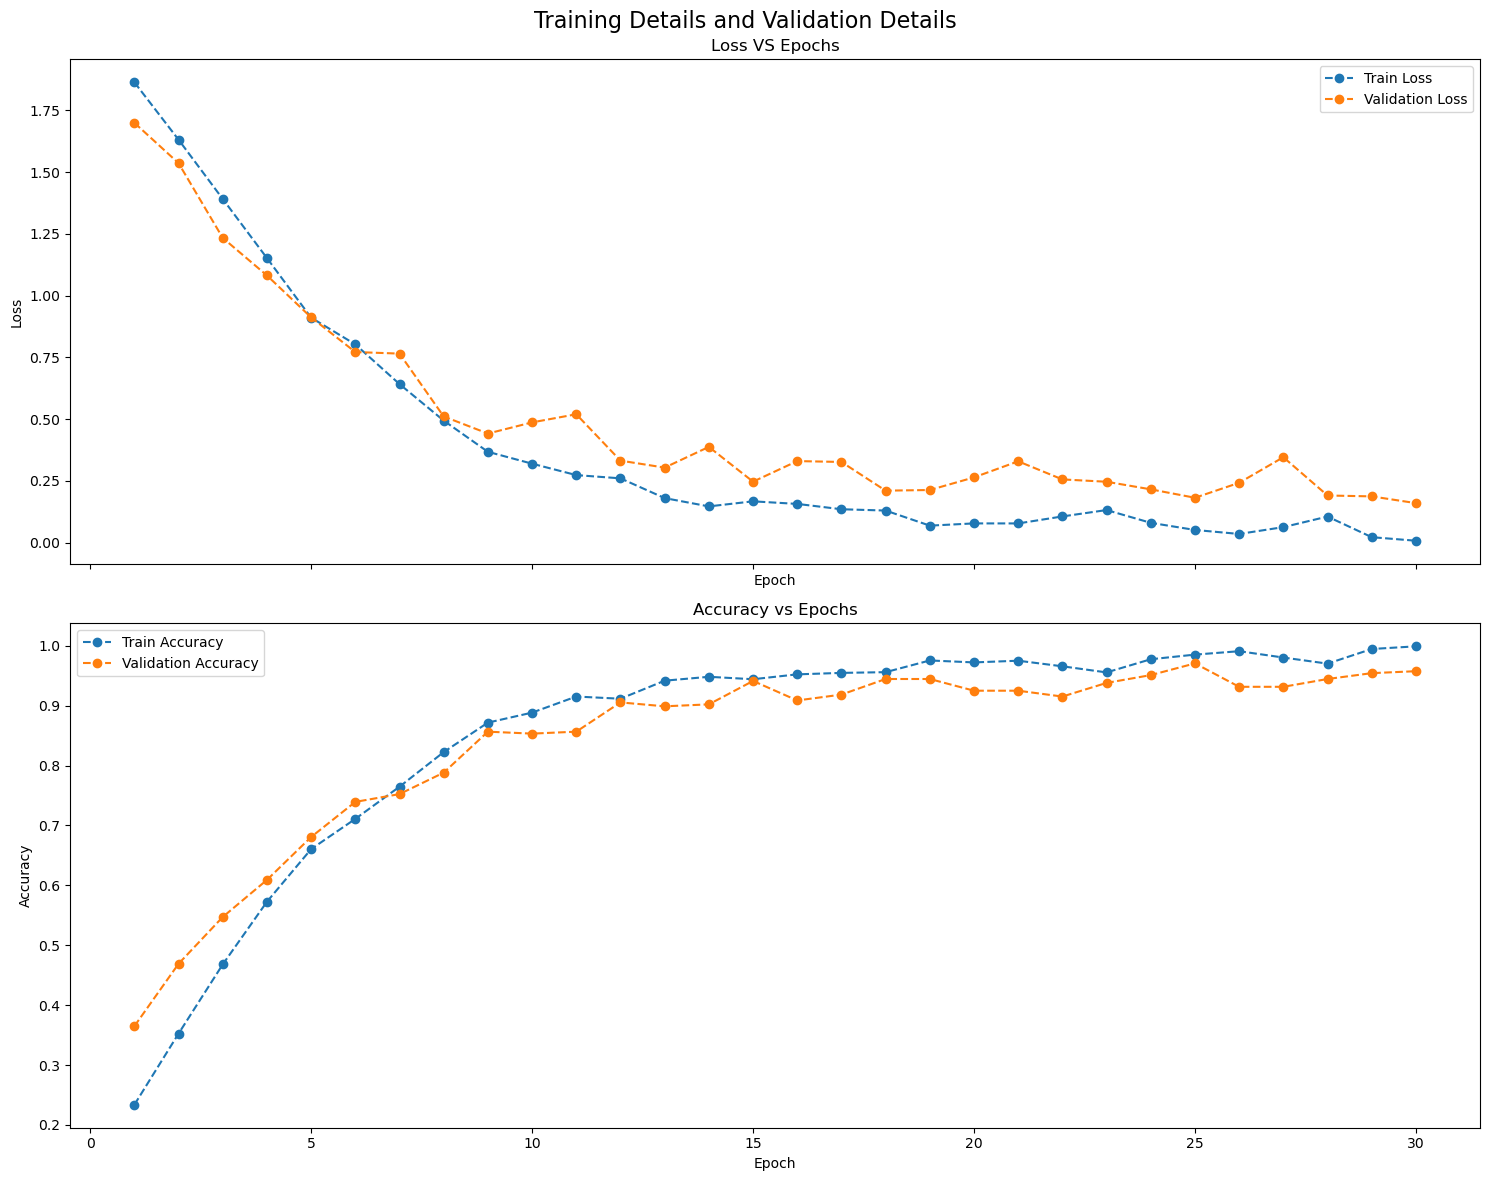

In [7]:
epochs = 30
batch_size = 32
lr = 1e-3
model_data, meta, best_model, best_meta, X_test, y_test= train(X, y, meta, epochs, batch_size, lr)

### (ii) Training the Model with these Hyperparameter Values
- Epochs = 30
- Batch Size = 64
- Learning Rate = 1e-3 = 0.001

Splits: Train - 2457 , Validation - 307 , Test - 308
[LSTM] Epoch 1 TrainLoss 1.9122 TrainAccuracy 0.2267 ValidationLoss 1.7571 ValidationAccuracy 0.3420
[LSTM] Epoch 2 TrainLoss 1.6614 TrainAccuracy 0.3325 ValidationLoss 1.5267 ValidationAccuracy 0.4072
[LSTM] Epoch 3 TrainLoss 1.4863 TrainAccuracy 0.4208 ValidationLoss 1.3319 ValidationAccuracy 0.5309
[LSTM] Epoch 4 TrainLoss 1.2729 TrainAccuracy 0.5165 ValidationLoss 1.2195 ValidationAccuracy 0.5407
[LSTM] Epoch 5 TrainLoss 1.1521 TrainAccuracy 0.5608 ValidationLoss 1.3431 ValidationAccuracy 0.5081
[LSTM] Epoch 6 TrainLoss 1.0011 TrainAccuracy 0.6243 ValidationLoss 0.9741 ValidationAccuracy 0.6417
[LSTM] Epoch 7 TrainLoss 0.8573 TrainAccuracy 0.6838 ValidationLoss 1.0290 ValidationAccuracy 0.6221
[LSTM] Epoch 8 TrainLoss 0.7620 TrainAccuracy 0.7257 ValidationLoss 0.7910 ValidationAccuracy 0.7264
[LSTM] Epoch 9 TrainLoss 0.5597 TrainAccuracy 0.8087 ValidationLoss 0.6224 ValidationAccuracy 0.7655
[LSTM] Epoch 10 TrainLoss 0.4806 Train

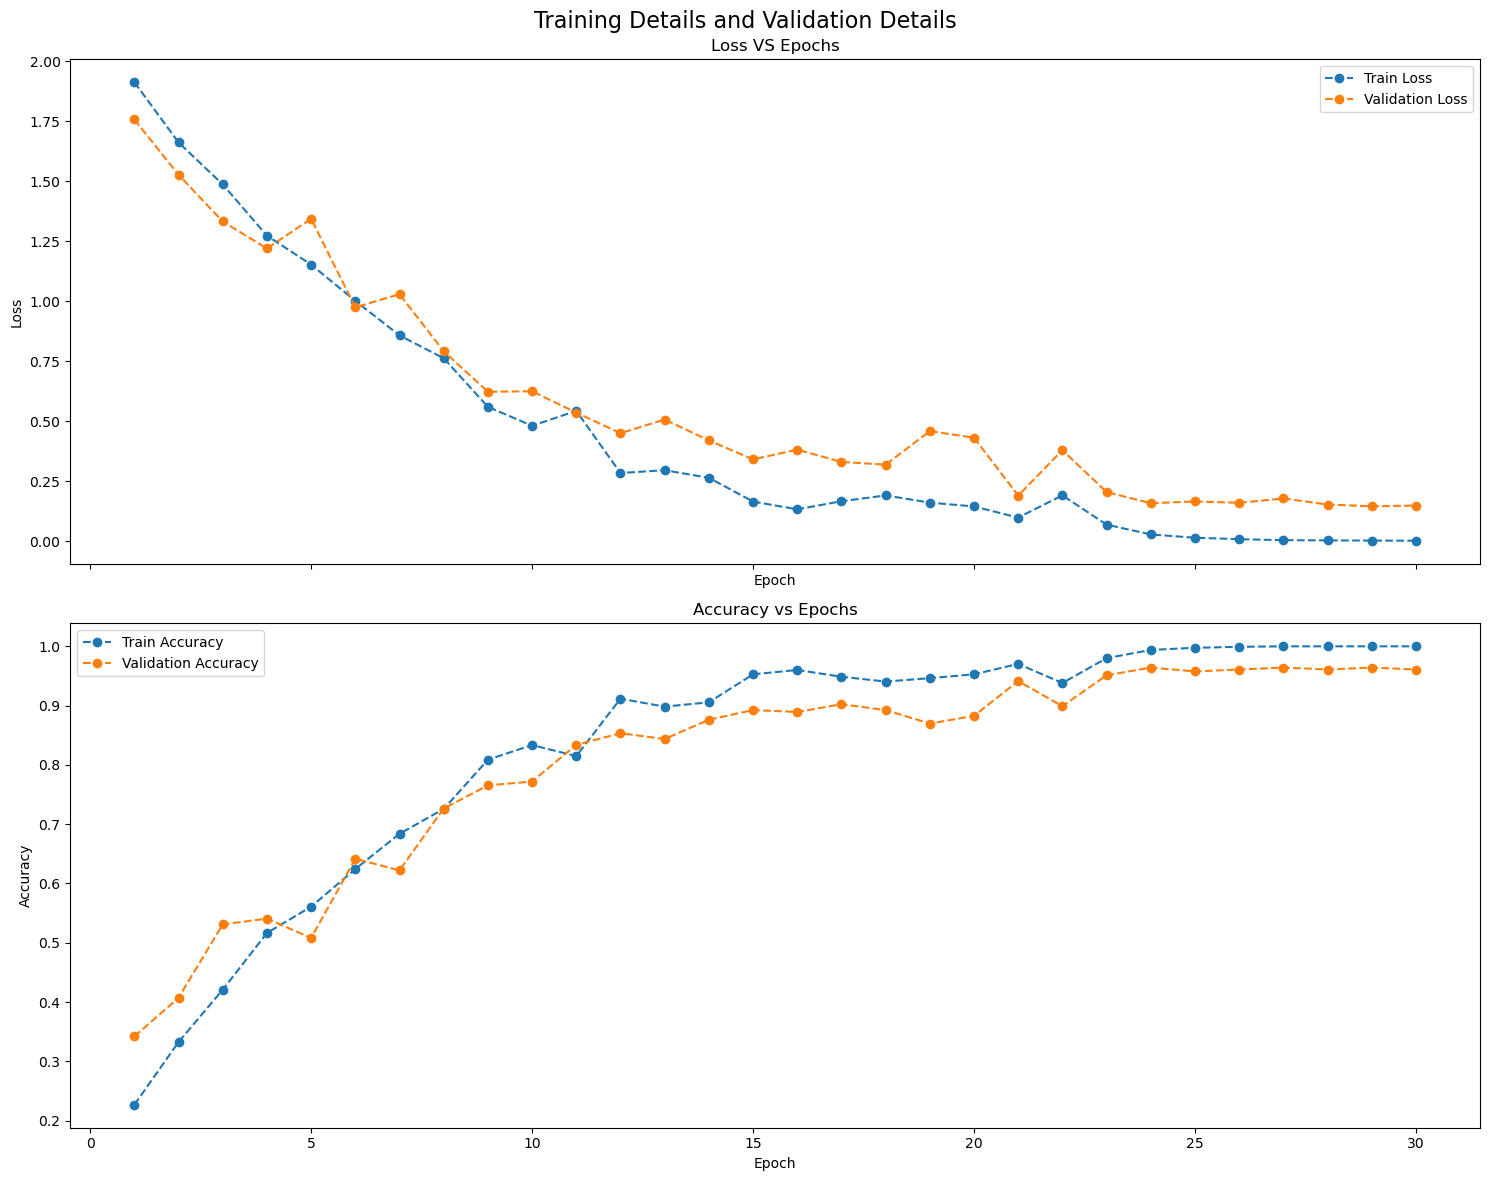

In [8]:
epochs = 30
batch_size = 64
lr = 1e-3
model_data, meta, best_model, best_meta, X_test, y_test= train(X, y, meta, epochs, batch_size, lr)

### (iii) Training the Model with these Hyperparameter Values
- Epochs = 30
- Batch Size = 32
- Learning Rate = 1e-4 = 0.0001

Splits: Train - 2457 , Validation - 307 , Test - 308
[LSTM] Epoch 1 TrainLoss 2.0609 TrainAccuracy 0.1791 ValidationLoss 2.0237 ValidationAccuracy 0.1857
[LSTM] Epoch 2 TrainLoss 1.9370 TrainAccuracy 0.2527 ValidationLoss 1.8386 ValidationAccuracy 0.2443
[LSTM] Epoch 3 TrainLoss 1.7679 TrainAccuracy 0.3024 ValidationLoss 1.7725 ValidationAccuracy 0.3583
[LSTM] Epoch 4 TrainLoss 1.6723 TrainAccuracy 0.3415 ValidationLoss 1.6460 ValidationAccuracy 0.3779
[LSTM] Epoch 5 TrainLoss 1.5753 TrainAccuracy 0.3748 ValidationLoss 1.5412 ValidationAccuracy 0.4007
[LSTM] Epoch 6 TrainLoss 1.4728 TrainAccuracy 0.4155 ValidationLoss 1.4420 ValidationAccuracy 0.4495
[LSTM] Epoch 7 TrainLoss 1.3918 TrainAccuracy 0.4473 ValidationLoss 1.3673 ValidationAccuracy 0.4691
[LSTM] Epoch 8 TrainLoss 1.3043 TrainAccuracy 0.4904 ValidationLoss 1.3193 ValidationAccuracy 0.5114
[LSTM] Epoch 9 TrainLoss 1.2384 TrainAccuracy 0.5189 ValidationLoss 1.2602 ValidationAccuracy 0.5831
[LSTM] Epoch 10 TrainLoss 1.1471 Train

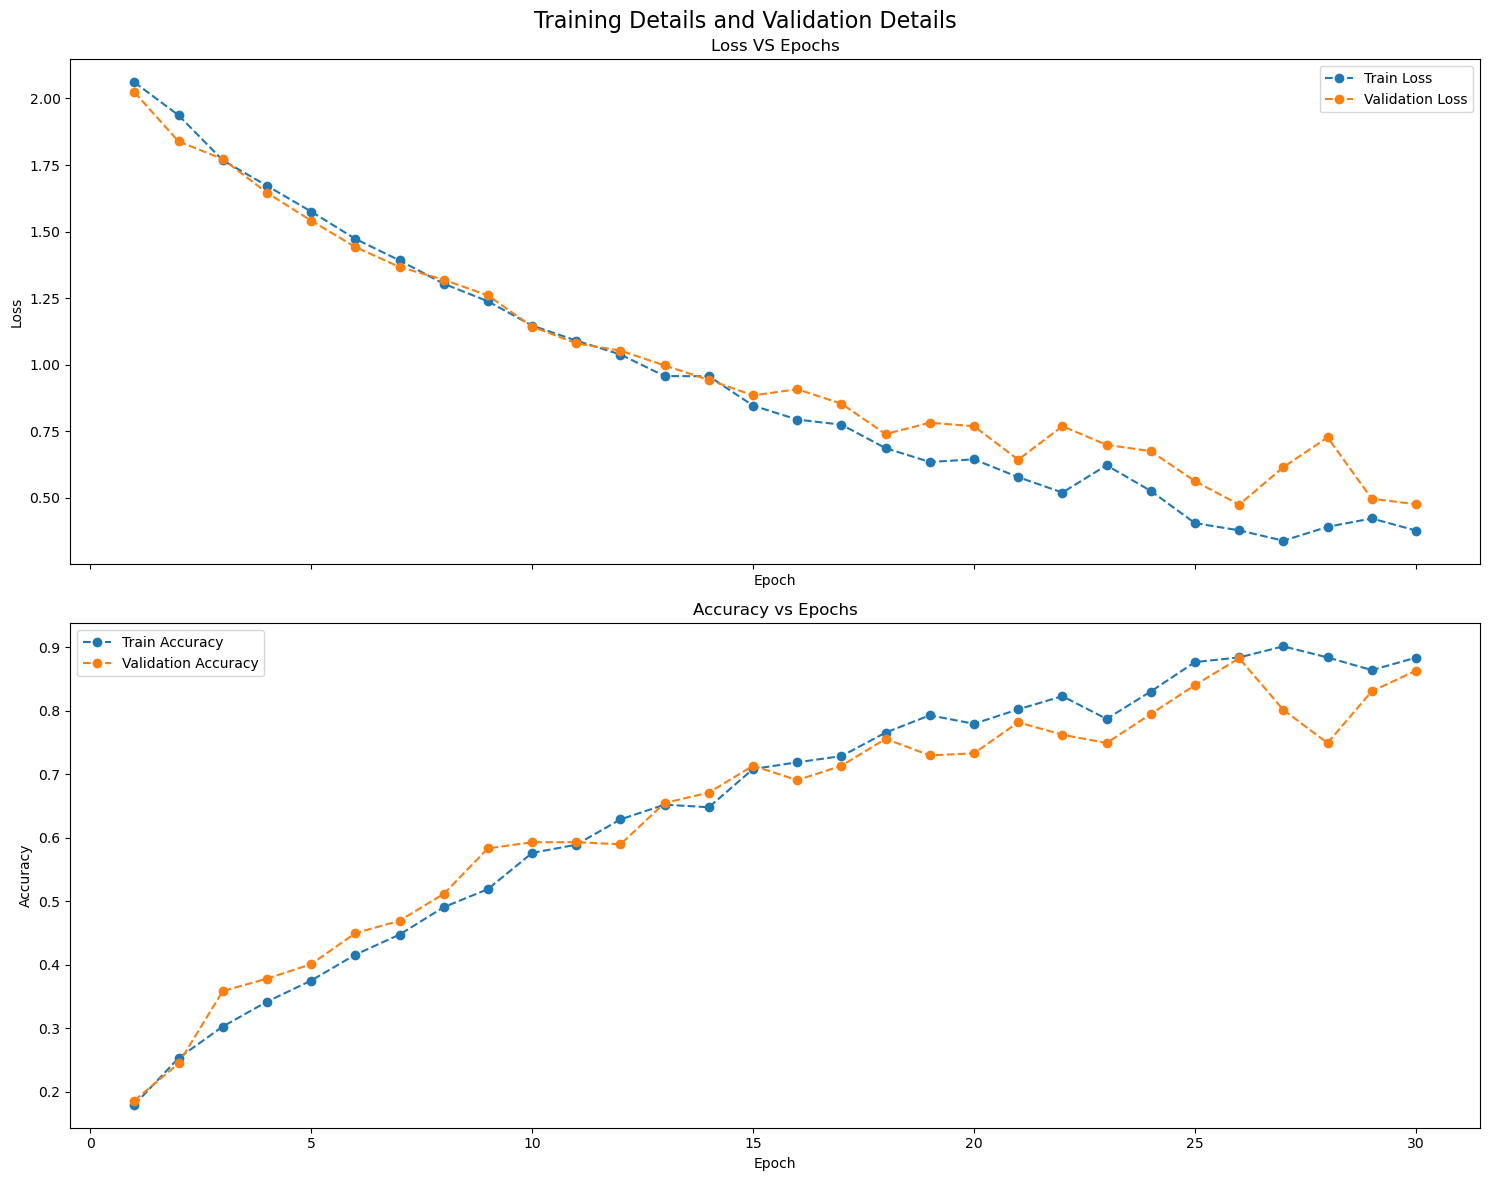

In [10]:
epochs = 30
batch_size = 32
lr = 1e-4
model_data, meta, best_model, best_meta, X_test, y_test= train(X, y, meta, epochs, batch_size, lr)

### (iv) Training the Model with these Hyperparameter Values
- Epochs = 40
- Batch Size = 32
- Learning Rate = 1e-3 = 0.001

Splits: Train - 2457 , Validation - 307 , Test - 308
[LSTM] Epoch 1 TrainLoss 1.8634 TrainAccuracy 0.2336 ValidationLoss 1.6994 ValidationAccuracy 0.3648
[LSTM] Epoch 2 TrainLoss 1.6309 TrainAccuracy 0.3525 ValidationLoss 1.5360 ValidationAccuracy 0.4691
[LSTM] Epoch 3 TrainLoss 1.3911 TrainAccuracy 0.4681 ValidationLoss 1.2334 ValidationAccuracy 0.5472
[LSTM] Epoch 4 TrainLoss 1.1519 TrainAccuracy 0.5726 ValidationLoss 1.0816 ValidationAccuracy 0.6091
[LSTM] Epoch 5 TrainLoss 0.9108 TrainAccuracy 0.6606 ValidationLoss 0.9118 ValidationAccuracy 0.6808
[LSTM] Epoch 6 TrainLoss 0.8027 TrainAccuracy 0.7110 ValidationLoss 0.7717 ValidationAccuracy 0.7394
[LSTM] Epoch 7 TrainLoss 0.6420 TrainAccuracy 0.7648 ValidationLoss 0.7653 ValidationAccuracy 0.7524
[LSTM] Epoch 8 TrainLoss 0.4942 TrainAccuracy 0.8225 ValidationLoss 0.5109 ValidationAccuracy 0.7883
[LSTM] Epoch 9 TrainLoss 0.3679 TrainAccuracy 0.8718 ValidationLoss 0.4418 ValidationAccuracy 0.8567
[LSTM] Epoch 10 TrainLoss 0.3199 Train

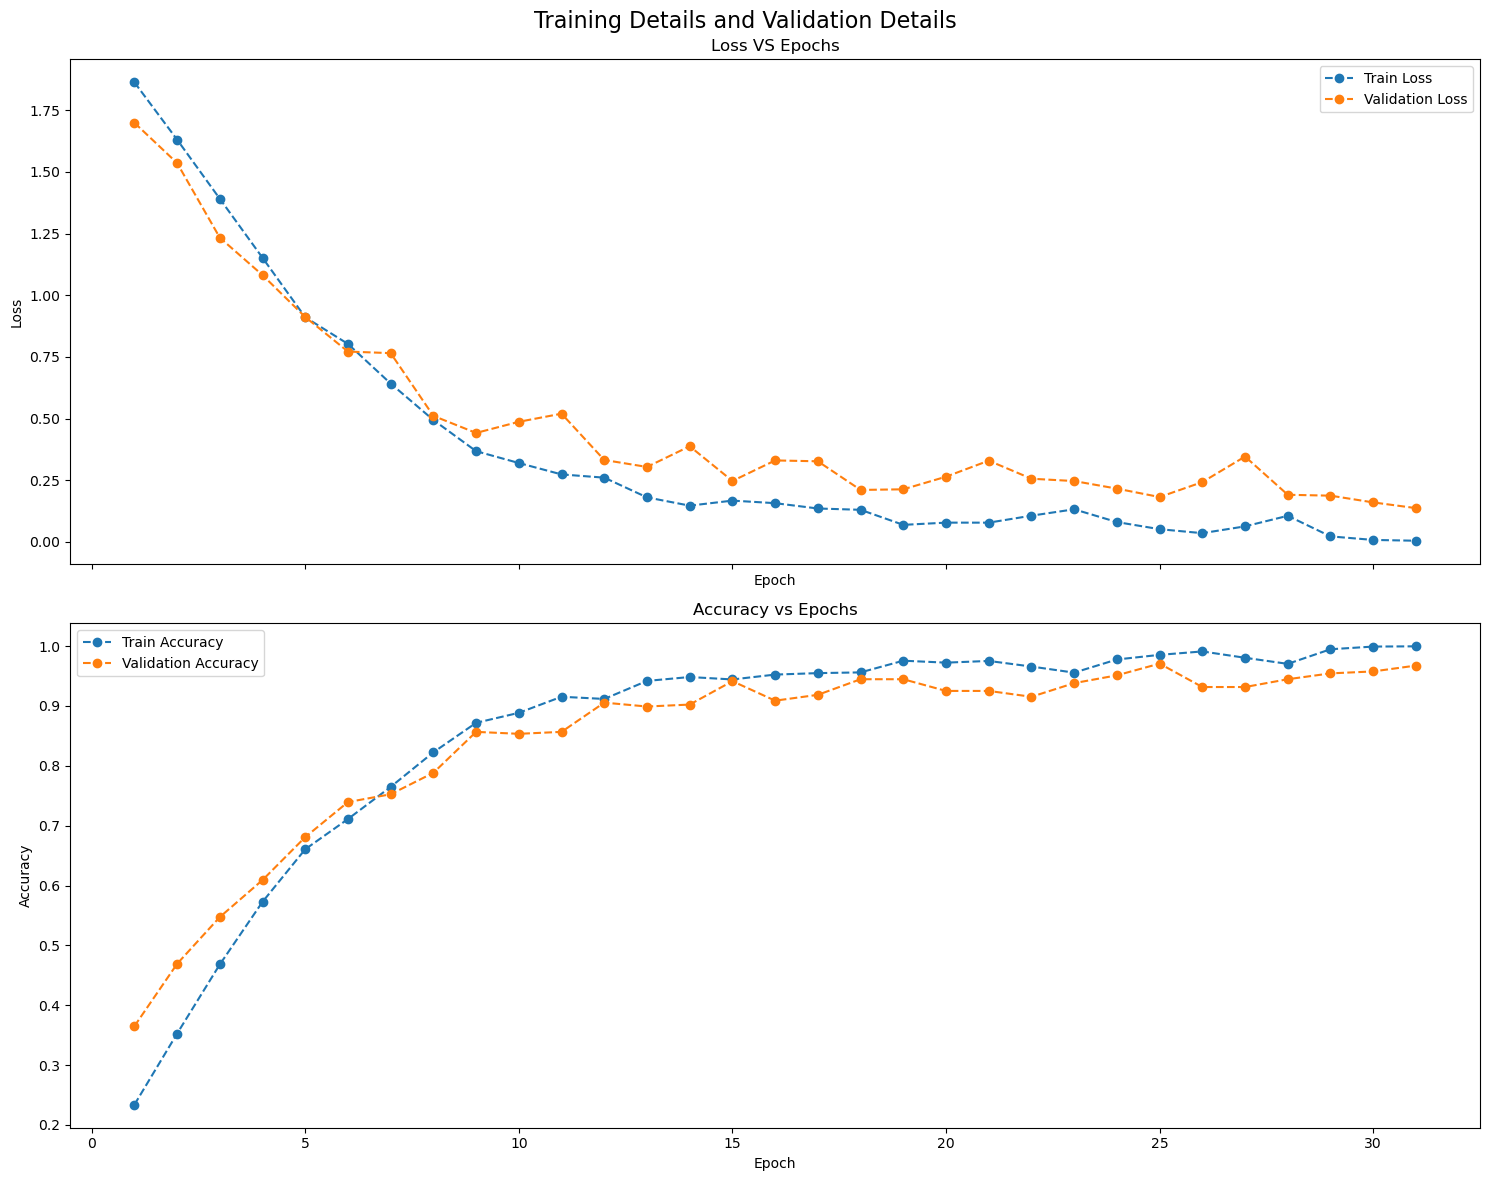

In [9]:
epochs = 40
batch_size = 32
lr = 1e-3
model_data, meta, best_model, best_meta, X_test, y_test= train(X, y, meta, epochs, batch_size, lr)

#### By Observing all the Graphs, (iv) is the model with the Best Hyperparameter Values
#### Therefore,
- Best Epochs = 40
- Best Batch Size = 32
- Best Learning Rate = 1e-3 = 0.001

## 06) Saving the Models with Best Hyperparameter Values

In [12]:
best_path = os.path.join(OUT_DIR, "lstm_best.pt")
torch.save({'state_dict': model_data, 'meta': meta}, best_path)
print(f"Saved Best Model:, '{best_path}'")

save_path = os.path.join(OUT_DIR, "lstm.pt")
torch.save({'state_dict': model_data, 'meta': meta}, save_path)
print(f"Saved Best Model:, '{save_path}")

Saved Best Model:, '../../models/LSTM/lstm_best.pt'
Saved Best Model:, '../../models/LSTM/lstm.pt


## 07) Evaluating the LSTM Model with Test Set of Data

In [13]:
def evaluate_model(X, y, meta, X_test, y_test):
    random.seed(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    N, T, D = X.shape
    model = LSTMClassifier(feat_dim=D, n_classes=8).to(DEVICE)
    criterion = nn.CrossEntropyLoss()
    model.load_state_dict(torch.load(best_path, map_location=DEVICE)['state_dict'])
    test_dataset = TensorDataset(X_test, y_test)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    model.eval()
    total_loss = 0.0
    total = 0
    correct = 0
    all_preds = []
    with torch.no_grad():
        for xb, yb in test_loader:
            xb = xb.to(DEVICE)
            yb = yb.to(DEVICE)
            out = model(xb)
            loss = criterion(out, yb)
            total_loss += loss.item() * xb.size(0)
            preds = out.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            correct += (preds == yb).sum().item()
            total += xb.size(0)
    test_loss = total_loss/total
    test_accuracy = correct/total

    total_accuracy_score = accuracy_score(y_test, all_preds)
    full_classification_report = classification_report(y_test, all_preds, digits=4)
    final_f1_score = f1_score(y_test, all_preds, average='macro', zero_division=0)
    return test_loss, total_accuracy_score, final_f1_score, full_classification_report, all_preds

## 08) Accuracy, Classification Report and Confusion Matrix

--------Test Set Performance--------

Test Loss: 0.4686501831203312
Accuracy: 0.8506493506493507
Macro F1 Score: 0.8500732237758984


--------Classification Report--------

               precision    recall  f1-score   support

           0     0.9487    0.9737    0.9610        38
           1     0.8974    0.9211    0.9091        38
           2     0.7059    0.9474    0.8090        38
           3     0.8182    0.6923    0.7500        39
           4     0.9024    0.9487    0.9250        39
           5     0.8611    0.7949    0.8267        39
           6     0.9355    0.7632    0.8406        38
           7     0.7895    0.7692    0.7792        39

    accuracy                         0.8506       308
   macro avg     0.8573    0.8513    0.8501       308
weighted avg     0.8572    0.8506    0.8497       308



--------Confusion Maxtrix--------


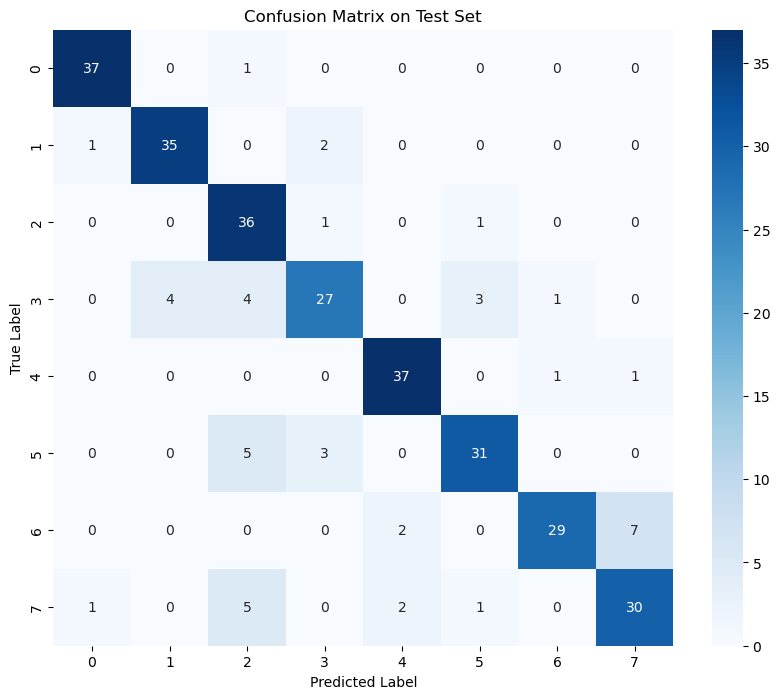

In [14]:
test_loss, total_accuracy_score, final_f1_score, full_classification_report, all_preds =  evaluate_model(X, y, meta, X_test, y_test)
print("--------Test Set Performance--------")
print(f"\nTest Loss: {test_loss}")
print(f"Accuracy: {total_accuracy_score}")
print(f"Macro F1 Score: {final_f1_score}\n\n")
print(f"--------Classification Report--------\n\n {full_classification_report}\n\n")

print("--------Confusion Maxtrix--------")
final_confusion_matrix = confusion_matrix(y_test, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(final_confusion_matrix, annot=True, fmt='d', cmap='Blues')
plt.title(f'Confusion Matrix on Test Set')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()